In [207]:
from selenium import webdriver
from bs4 import BeautifulSoup
import polars as pl
import time

### /records-research/record-cfa-actions

#### Page Image

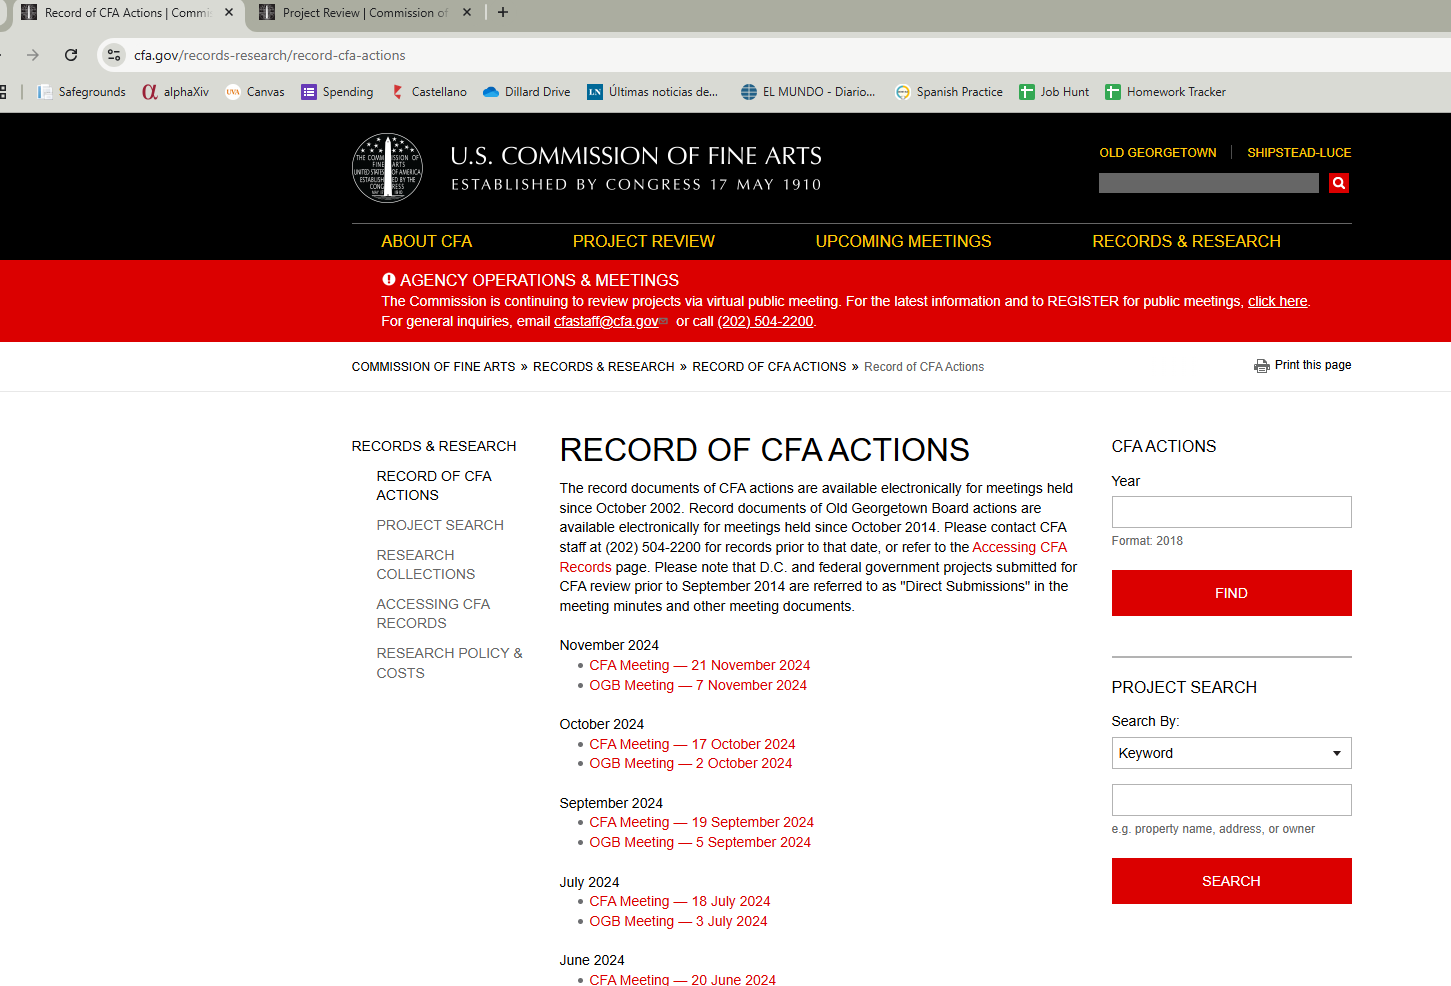

#### Code

In [ ]:
# Initialize the WebDriver
driver = webdriver.Chrome()

# Navigate to the specified URL
driver.get("https://www.cfa.gov/records-research/record-cfa-actions?page=1")

In [6]:
# Load the page source into BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [26]:
records = soup.find(
    'div','l-page__primary l-page__inner' # Find the primary content area
    ).find(
        'div','view-content views__content' # Get the list of meetings
    ).find_all(
        'div','item-list' # Get each meeting month        
    )

In [30]:
records[0].text.split('\n')

['December 2023', 'OGB Meeting — 7 December 2023']

In [36]:
records[0].find('ul').find('a')['href']

'/records-research/record-cfa-actions/2023/12/ogb-meeting'

In [37]:
# Close the WebDriver
driver.quit()

### /records-research/project-search

#### Page Image

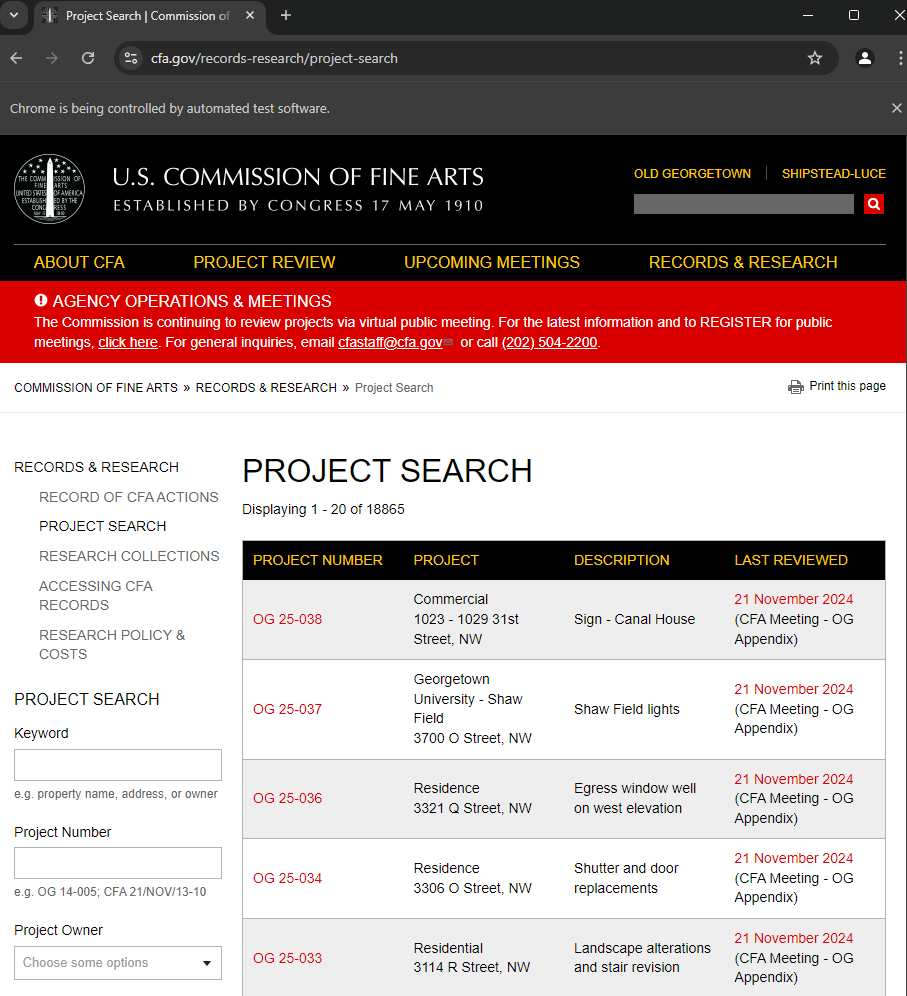

#### Functions

In [256]:
def start_driver(url,options=None):
    """
    Initializes a Chrome WebDriver instance and navigates to the specified URL.
    Args:
        start_url (str): The URL to navigate to after starting the WebDriver.
    Returns:
        WebDriver: An instance of the Chrome WebDriver.
    """
    driver = webdriver.Chrome(options=options)
    driver.get(url)

    return driver

def get_soup(driver):
    """
    Extracts and parses the HTML content from a web page using a Selenium WebDriver.
    Args:
        driver (selenium.webdriver.remote.webdriver.WebDriver): The Selenium WebDriver instance used to interact with the web page.
    Returns:
        bs4.BeautifulSoup: A BeautifulSoup object containing the parsed HTML content of the web page.
    """
    return BeautifulSoup(driver.page_source, 'html.parser')

def get_project_table(soup):
    """
    Extracts CFA and OGB-specific project data from an HTML soup object and returns it as a Polars DataFrame.
    Args:
        soup (BeautifulSoup): A BeautifulSoup object containing the HTML content to parse.
    Returns:
        pl.DataFrame: A Polars DataFrame containing the extracted project data with the following columns:
            - project_number (str): The project number.
            - project_link (str): The URL link to the project.
            - project_type (str): The type of the project.
            - project_location (list): A list containing the project location details (e.g., [address, country]).
            - project_description (str): A description of the project.
            - last_reviewed (str): The datetime when the project was last reviewed.
            - last_reviewed_meeting (str): The URL link to the last reviewed meeting.
            - review_type (str): The type of review conducted on the project.
    """
    
    ##GET THE PROJECT TABLE AREA####################################################
    try:
        projects = soup.find(
            'div','l-page__primary l-page__inner' # Find the primary content area
            ).find(
                'div','view-content views__content' # Get the project display area
            ).find('table') # Get the table of projects
    except AttributeError:
        print("No project table found.")
        return None

    ##ITERATE THROUGH EACH ROW IN THE TABLE#########################################
    project_data = []

    for row in projects.find('tbody').find_all('tr'): # Get each row of the table
        try:
            global columns
            columns = row.find_all('td') # Get the data for each row

            # project number and link
            project_number = columns[0].text.strip()
            project_link = columns[0].find('a')['href'].strip()

            # project type and location
            project_type = columns[1].text.split()[0].strip()
            project_location = [loc.text for loc in columns[1].find('p').find_all('span')]

            # project description
            project_description = columns[2].text.strip()

            # project review
            last_reviewed = columns[3].find('time')['datetime']
            last_reviewed_meeting = columns[3].find('a')['href']

            # last reviewed by which group
            to_remove = columns[3].find_all(['a', 'br'])
            [tag.extract() for tag in to_remove]
            review_type = columns[3].text.strip()

            project_data.append({
                'project_number': project_number,
                'project_link': project_link,
                'project_type': project_type,
                'project_location': project_location,
                'project_description': project_description,
                'last_reviewed': last_reviewed,
                'last_reviewed_meeting': last_reviewed_meeting,
                'review_type': review_type
            })
        except AttributeError:
            print(f"Error parsing project data for row: {row}")
            continue

    ###PUT DATA INTO POLARS DATAFRAME#############################################
    df = pl.DataFrame(project_data)
    return df

#### Grab and Save Pages (~100 mins)

In [255]:
def iterate_page(driver, page_number):
    """
    Iterates through the pages of the CFA project search results and extracts the project data.
    Args:
        driver (selenium.webdriver.remote.webdriver.WebDriver): The Selenium WebDriver instance used to interact with the web page.
        page_number (int): The page number to navigate to and extract the project data from.
    Returns:
        pl.DataFrame: A Polars DataFrame containing the extracted project data from the specified page.
    """
    # Navigate to the specified page number
    driver.get(f"https://www.cfa.gov/records-research/project-search?page={page_number}")
    # Load the page source into BeautifulSoup
    global soup
    soup = get_soup(driver)

    # Extract the project data from the page
    project_data = get_project_table(soup)

    return project_data

In [ ]:
# Initialize the WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = start_driver("https://www.cfa.gov/records-research/project-search", options=options)

# Prepare empty dataframe to store all project data
all_project_data = pl.DataFrame()

# Initialize the page number
init_page_number = 0
page_number = 0

# Load the page source into BeautifulSoup to get the initial page to check the while loop
soup = get_soup(driver)

# Iterate through the pages of the project search results until there is no "Last" button (i.e., the last page)
while soup.find('li', 'pager__item pager__item--directional pager__item--last') is not None:
    print('Page:', page_number)
    project_data = iterate_page(driver, page_number)
    page_number += 1
    if project_data is not None:
        all_project_data = pl.concat([all_project_data, project_data])
    else:
        page_number -= 1
        time.sleep(1)

driver.quit()

ERROR ROWS:

Page: 157
Error parsing project data for row.

Page: 423
No project table found.


In [ ]:
# all_project_data.write_parquet(f'../Data_Raw/project_tables/ogb_{init_page_number}_{page_number}.parquet')